In [9]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
import torchvision.transforms as standard_transforms

import numpy as np
import glob

from data_loader import Rescale
from data_loader import RescaleT
from data_loader import RandomCrop
from data_loader import CenterCrop
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset

from model import BASNet

import pytorch_ssim
import pytorch_iou

In [10]:
# ------- 1. define loss function --------

bce_loss = nn.BCELoss(size_average=True)
ssim_loss = pytorch_ssim.SSIM(window_size=11,size_average=True)
iou_loss = pytorch_iou.IOU(size_average=True)

def bce_ssim_loss(pred,target):

	bce_out = bce_loss(pred,target)
	ssim_out = 1 - ssim_loss(pred,target)
	iou_out = iou_loss(pred,target)

	loss = bce_out + ssim_out + iou_out

	return loss

def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, d7, labels_v):

	loss0 = bce_ssim_loss(d0,labels_v)
	loss1 = bce_ssim_loss(d1,labels_v)
	loss2 = bce_ssim_loss(d2,labels_v)
	loss3 = bce_ssim_loss(d3,labels_v)
	loss4 = bce_ssim_loss(d4,labels_v)
	loss5 = bce_ssim_loss(d5,labels_v)
	loss6 = bce_ssim_loss(d6,labels_v)
	loss7 = bce_ssim_loss(d7,labels_v)
	#ssim0 = 1 - ssim_loss(d0,labels_v)

	# iou0 = iou_loss(d0,labels_v)
	#loss = torch.pow(torch.mean(torch.abs(labels_v-d0)),2)*(5.0*loss0 + loss1 + loss2 + loss3 + loss4 + loss5) #+ 5.0*lossa
	loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7#+ 5.0*lossa
	print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n"%(loss0.item(),loss1.item(),loss2.item(),loss3.item(),loss4.item(),loss5.item(),loss6.item()))	# print("BCE: l1:%3f, l2:%3f, l3:%3f, l4:%3f, l5:%3f, la:%3f, all:%3f\n"%(loss1.data[0],loss2.data[0],loss3.data[0],loss4.data[0],loss5.data[0],lossa.data[0],loss.data[0]))

	return loss0, loss

In [11]:
# ------- 2. set the directory of training dataset --------

data_dir = './train_data/'
tra_image_dir = 'DUTS/DUTS-TR/DUTS-TR/im_aug/'
tra_image_dir = 'DUTS/image/'
tra_label_dir = 'DUTS/DUTS-TR/DUTS-TR/gt_aug/'
tra_label_dir = 'DUTS/mask/'
image_ext = '.jpg'
label_ext = '.png'

model_dir = "./saved_models/basnet_bsi/"

In [12]:
len(glob.glob(data_dir + tra_image_dir + '*' + image_ext))

10553

In [13]:
epoch_num = 100000
batch_size_train = 8 
batch_size_val = 1
train_num = 0
val_num = 0

tra_img_name_list = glob.glob(data_dir + tra_image_dir + '*' + image_ext)

tra_lbl_name_list = []
for img_path in tra_img_name_list:
	img_name = img_path.split("/")[-1]

	aaa = img_name.split(".")
	bbb = aaa[0:-1]
	imidx = bbb[0]
	for i in range(1,len(bbb)):
		imidx = imidx + "." + bbb[i]

	tra_lbl_name_list.append(data_dir + tra_label_dir + imidx + label_ext)

print("---")
print("train images: ", len(tra_img_name_list))
print("train labels: ", len(tra_lbl_name_list))
print("---")

---
train images:  10553
train labels:  10553
---


In [14]:
train_num = len(tra_img_name_list)

salobj_dataset = SalObjDataset(
    img_name_list=tra_img_name_list,
    lbl_name_list=tra_lbl_name_list,
    transform=transforms.Compose([
        RescaleT(256),
        RandomCrop(224),
        ToTensorLab(flag=0)]))
salobj_dataloader = DataLoader(salobj_dataset, batch_size=batch_size_train, shuffle=True, num_workers=1)

In [15]:
10553 - 2000

8553

In [18]:
round(len(tra_img_name_list) * 0.2)

2111

In [22]:
train_size

8442

In [23]:
valid_size

2111

In [6]:
# ------- 3. define model --------
# define the net
net = BASNet(3, 1)
if torch.cuda.is_available():
    net.cuda()

# ------- 4. define optimizer --------
print("---define optimizer...")
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# ------- 5. training process --------
print("---start training...")
ite_num = 0
running_loss = 0.0
running_tar_loss = 0.0
ite_num4val = 0


---define optimizer...
---start training...


In [8]:
for epoch in range(0, epoch_num):
    net.train()

    for i, data in enumerate(salobj_dataloader):
        ite_num = ite_num + 1
        ite_num4val = ite_num4val + 1

        inputs, labels = data['image'], data['label']

        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)

        # wrap them in Variable
        if torch.cuda.is_available():
            inputs_v, labels_v = Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(),
                                                                                        requires_grad=False)
        else:
            inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)

        # y zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        d0, d1, d2, d3, d4, d5, d6, d7 = net(inputs_v)
        loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, d7, labels_v)

        loss.backward()
        optimizer.step()

        # # print statistics
        running_loss += loss.item()
        running_tar_loss += loss2.item()

        # del temporary outputs and loss
        del d0, d1, d2, d3, d4, d5, d6, d7, loss2, loss

        print("[epoch: %3d/%3d, batch: %5d/%5d, ite: %d] train loss: %3f, tar: %3f " % (
        epoch + 1, epoch_num, (i + 1) * batch_size_train, train_num, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val))

        if ite_num % 5 == 0:  # save model every 2000 iterations

            torch.save(net.state_dict(), model_dir + "basnet_bsi_itr_%d_train_%3f_tar_%3f.pth" % (ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val))
            running_loss = 0.0
            running_tar_loss = 0.0
            net.train()  # resume train
            ite_num4val = 0

print('-------------Congratulations! Training Done!!!-------------')


l0: 2.228276, l1: 2.262005, l2: 2.328339, l3: 2.371608, l4: 2.479435, l5: 2.464025, l6: 2.216763

[epoch:   1/100000, batch:     8/10553, ite: 6] train loss: 18.176427, tar: 2.276349 
l0: 2.216382, l1: 2.289156, l2: 2.234293, l3: 2.302599, l4: 2.472068, l5: 2.245851, l6: 1.948349

[epoch:   1/100000, batch:    16/10553, ite: 7] train loss: 18.097825, tar: 2.267782 
l0: 1.878418, l1: 2.037543, l2: 2.084603, l3: 2.070390, l4: 2.017177, l5: 2.265259, l6: 2.011936

[epoch:   1/100000, batch:    24/10553, ite: 8] train loss: 17.875917, tar: 2.219111 
l0: 2.054188, l1: 2.278168, l2: 2.180347, l3: 2.214088, l4: 2.304202, l5: 2.177780, l6: 2.150492

[epoch:   1/100000, batch:    32/10553, ite: 9] train loss: 17.833552, tar: 2.200787 
l0: 2.026245, l1: 2.071383, l2: 2.049682, l3: 2.074501, l4: 2.021757, l5: 1.979734, l6: 2.125278

[epoch:   1/100000, batch:    40/10553, ite: 10] train loss: 17.694493, tar: 2.183332 


FileNotFoundError: [Errno 2] No such file or directory: './saved_models/basnet_bsi/basnet_bsi_itr_10_train_17.694493_tar_2.183332.pth'

In [1]:
import pandas as pd

In [2]:
import glob

In [7]:
!ls

LICENSE		__pycache__	 data_loader.py  pytorch_ssim  train_data
README.md	basnet.pth	 figures	 saved_models
README.md~	basnet_test.py	 model		 test_data
Untitled.ipynb	basnet_train.py  pytorch_iou	 train.py


In [12]:
path = 'train_data/NEW_DATA/image/*'

In [14]:
jpg = glob.glob(path)

In [15]:
path1 = 'train_data/NEW_DATA/mask/*'

In [16]:
png = glob.glob(path1)

In [23]:
new_jpg = []

In [24]:
for i in jpg:
    new_jpg.append(i.split('/')[-1][:-4])

In [27]:
new_png = []

In [28]:
for i in png:
    new_png.append(i.split('/')[-1][:-4])

In [33]:
for i in new_png:
    if i not in new_jpg:
        print(i + '.*')

0002629.*
0002618.*
0050080.*
A-133.*
0050070.*
0002521.*
0002794.*
A-63.*
0002509.*
0002631.*
0002598.*
0002595.*
0050000.*
E-00160.*
A-135.*
A-132.*
0002552.*
0050069.*
0002750.*
0002793.*
0002518.*
0050072.*


In [37]:
output =  glob.glob("/home/singhshivani158/BASNet/test_data/validation/output/*.png")

In [38]:
gt_image = [x.replace('output','gt') for x in output]

In [18]:
output = list(set(output))

In [19]:
gt_image = list(set(gt_image))

In [43]:
import glob
not_matching = []
import imageio

for index,image in enumerate(output):
    
    out = imageio.imread(image)
    gt =  imageio.imread(gt_image[index])
    if(out[:,:,0].shape != gt[:,:,0].shape):
        print(image)


/home/singhshivani158/BASNet/test_data/validation/output/G-46.png


In [26]:
output[0]

'/home/singhshivani158/BASNet/test_data/validation/output/G-3722.png'

In [25]:
imageio.imread(output[0]).shape

(400, 266, 3)

In [27]:
gt_image[0]


'/home/singhshivani158/BASNet/test_data/validation/gt/G-2560.png'

In [28]:
imageio.imread(gt_image[0]).shape

(400, 266, 4)

In [34]:
len(not_matching)

1048

In [35]:
len(output)

1055

## Mask

In [1]:
!ls

LICENSE      basnet_test.py	   model	 test.ipynb
MAE_plot     basnet_train.py	   new_train.py  test_data
README.md    command.sh		   pytorch_iou	 train.log
README.md~   data_loader.py	   pytorch_ssim  train.py
Train.ipynb  dataset_making.ipynb  runs		 train_data
__pycache__  figures		   saved_models  validation_form.ipynb
basnet.pth   logging.log	   split.ipynb


In [20]:
! ls ./test_data/new1_image/

he.jpeg  he2.jpeg  he3.jpeg  he4.jpeg  he5.jpeg


In [118]:
from PIL import Image
org = Image.open('./test_data/new1_image/he4.jpeg')

In [3]:
from glob import glob

In [7]:
glob('./*.jpg')

['./A-1.jpg']

In [9]:
import os
os.listdir(./*.jpg)

SyntaxError: invalid syntax (<ipython-input-9-fe51237b6d73>, line 2)

In [2]:
from PIL import Image
org = Image.open('A-1.jpg')




OSError: cannot identify image file 'A-1.jpg'

In [119]:
mask = Image.open('./test_data/new1_mask/he4.png').convert('L')

In [133]:
import numpy as np
mask = Image.open('./test_data/new1_mask/he4.png').convert('L')
arr = np.array(mask)
new_arr = (arr > 100).astype(int)
new_mask = Image.fromarray((new_arr * 255).astype(np.uint8))
new_mask.save('mask.png')

In [134]:
from PIL import ImageFilter

dilation_img = new_mask.filter(ImageFilter.MaxFilter(5))
erosion_img = new_mask.filter(ImageFilter.MinFilter(5))
blur_im = new_mask.filter(ImageFilter.BLUR)
smooth_im = new_mask.filter(ImageFilter.SMOOTH)
smooth_im_r = new_mask.filter(ImageFilter.SMOOTH_MORE)
blur_im_r = new_mask.filter(ImageFilter.BoxBlur(radius=1))

In [135]:
import numpy as np
arr = np.array(mask)

In [136]:
#set(arr.reshape(-1,))

In [137]:
import numpy as np
arr = np.array(mask)
new_arr = (arr > 100).astype(int)
new_mask = Image.fromarray((new_arr * 255).astype(np.uint8))
org.putalpha(new_mask)

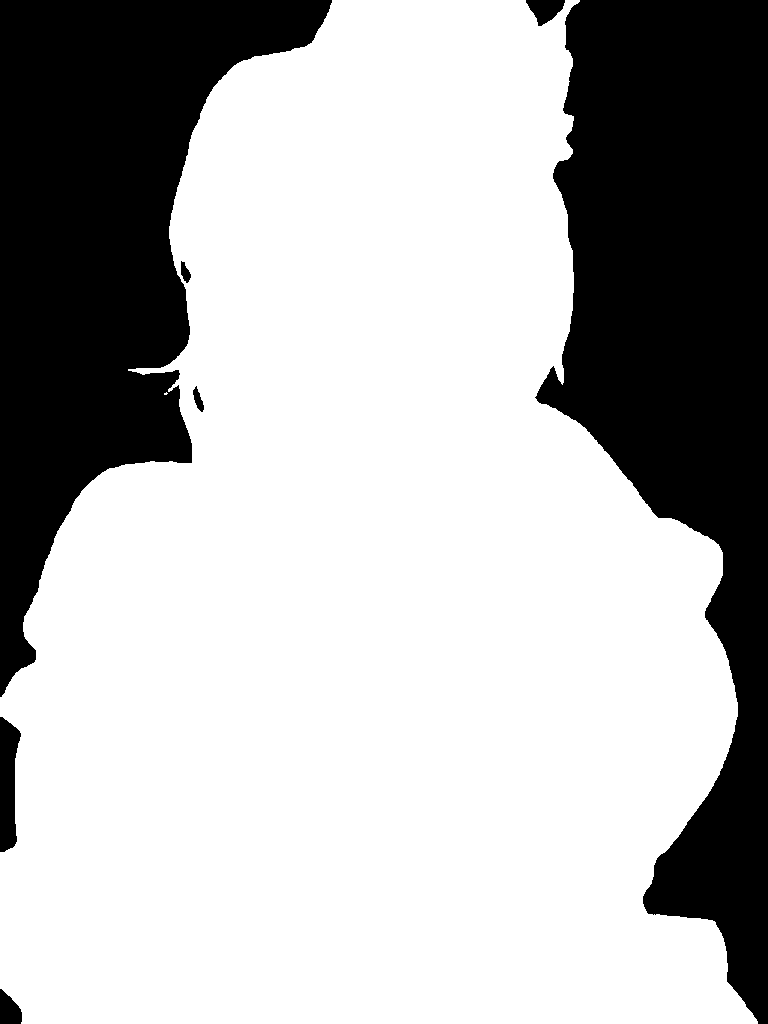

In [140]:
new_mask

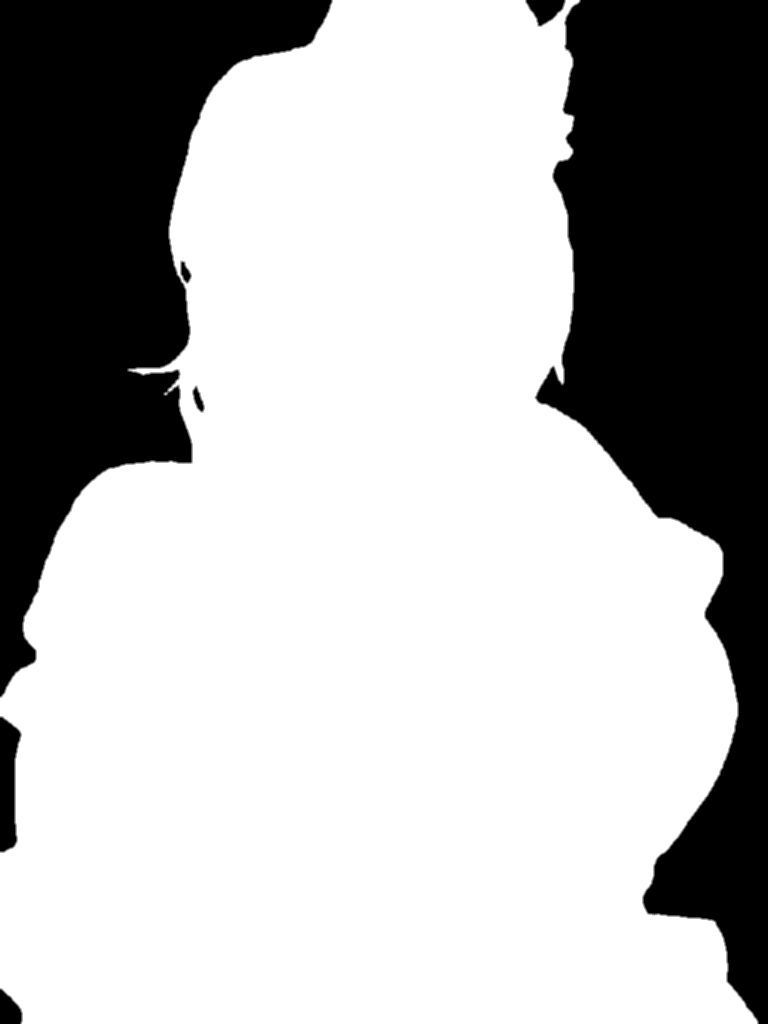

In [139]:
blur_im_r

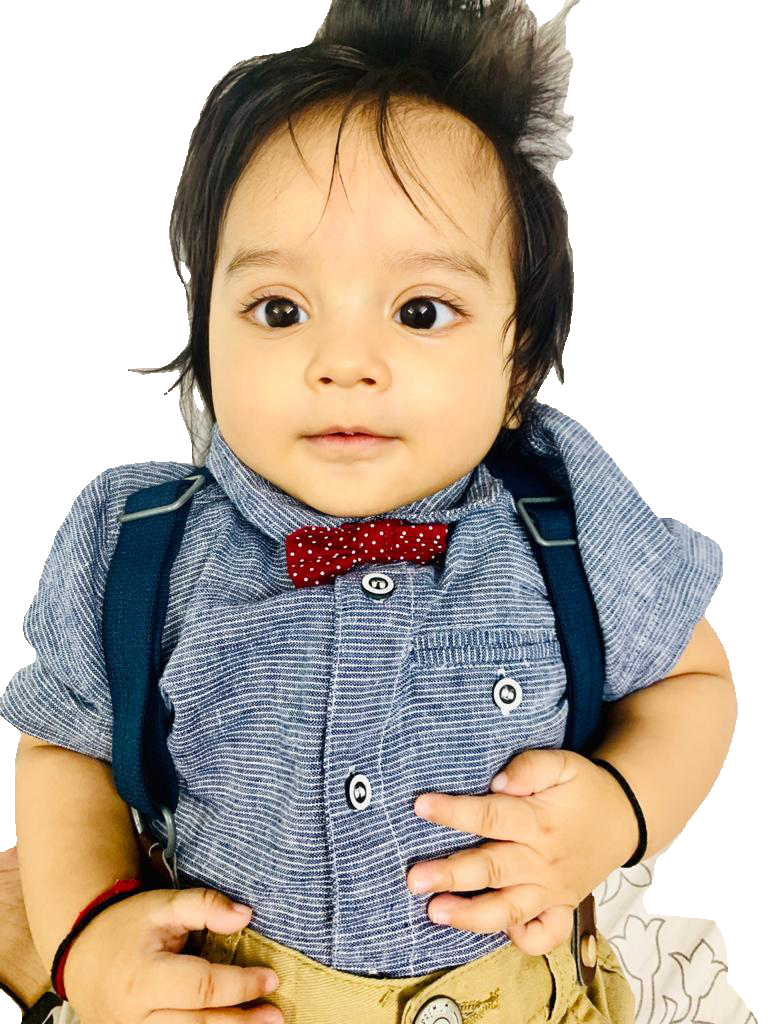

In [138]:
org

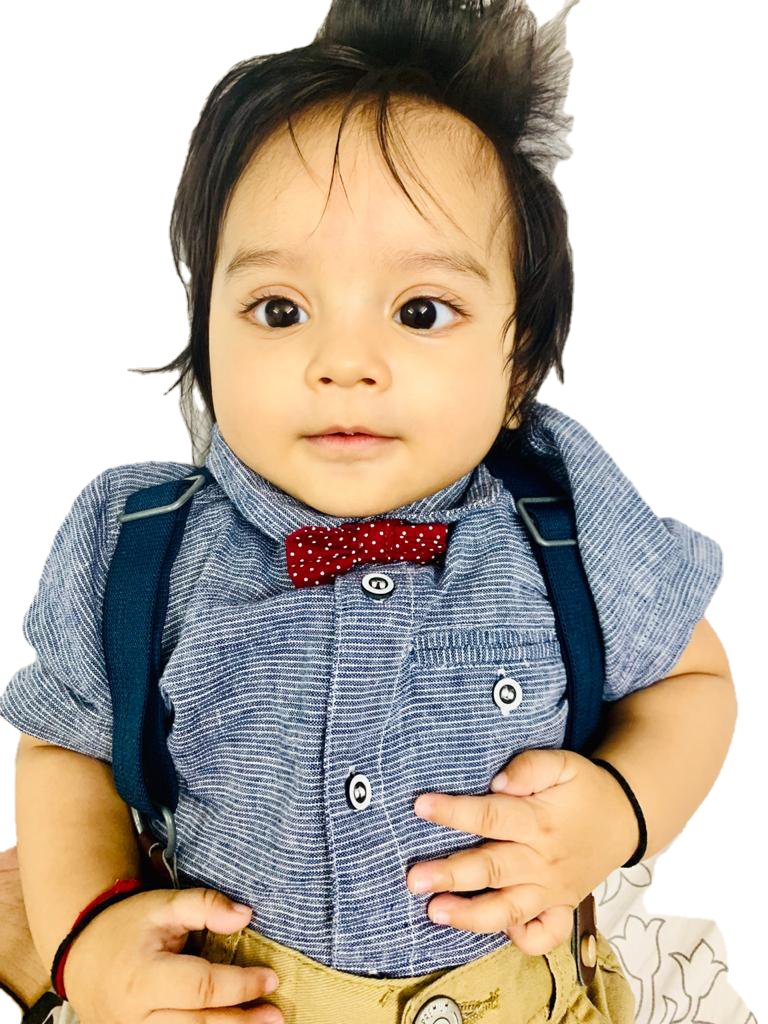

In [131]:
org

In [108]:
org.save('o_he_sr.png')

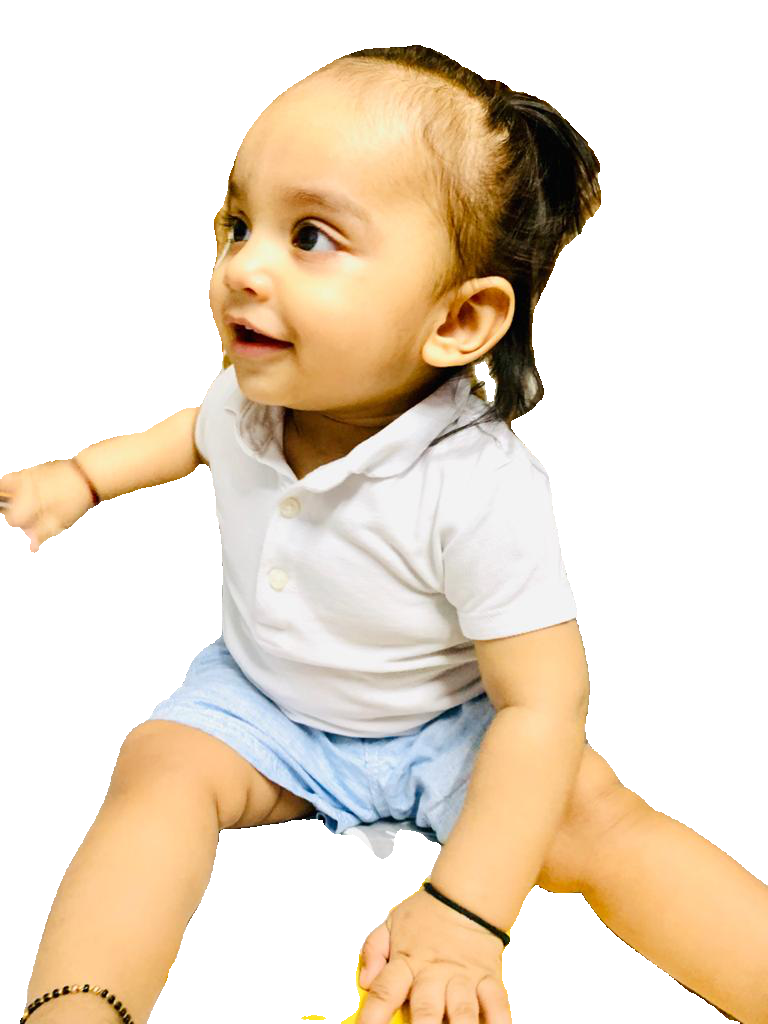

In [48]:
org